In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 53% 32.0M/60.3M [00:00<00:00, 173MB/s]
100% 60.3M/60.3M [00:00<00:00, 216MB/s]


In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imghdr
import os
import random
import cv2
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

from sklearn.metrics import classification_report, confusion_matrix

<ipython-input-3-2c5ae3df9f24>:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
project_name="FER_2013_Emotion_Detection"
model_name=[
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]
base_dir='/content/'
project_dir=os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)
for each_model in model_name:
  model_dir=os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok=True)


print(f"Project Directory Created at {project_dir}")

Project Directory Created at /content/FER_2013_Emotion_Detection


In [ ]:
image_exts=['jpeg','jpg','png']
data_dir='/content/train'
for root,dirs,files in os.walk(data_dir):
  for file in files:
    file_path=os.path.join(root,file)
    try:
        file_type=imghdr.what(file_path)
        if file_type not in image_exts:
          print(f'image not in ext list {file_path}')
          os.remove(file_path)
        else:
          img=cv2.imread(file_path)
    except Exception as e:
      print(f'Issue with image {file_path}')
      os.remove(file_path)


In [ ]:
def count_files_in_subdirs(directory,set_name):
  counts={}
  for item in os.listdir(directory):
    item_path=os.path.join(directory,item)
    if os.path.isdir(item_path):
      count=len([file for file in os.listdir(item_path) if os.path.isfile(os.path.join(item_path,file))])
      counts[item]=count
  df = pd.DataFrame(counts,index=[set_name])
  return df
train_dir='/content/train'
test_dir='/content/test'

train_count=count_files_in_subdirs(train_dir,'train')
test_count=count_files_in_subdirs(test_dir,'test')
print(train_count)
print(test_count)


       surprise  neutral  happy  fear  disgust   sad  angry
train      3171     4965   7215  4097      436  4830   3995
      surprise  neutral  happy  fear  disgust   sad  angry
test       831     1233   1774  1024      111  1247    958


<Axes: >

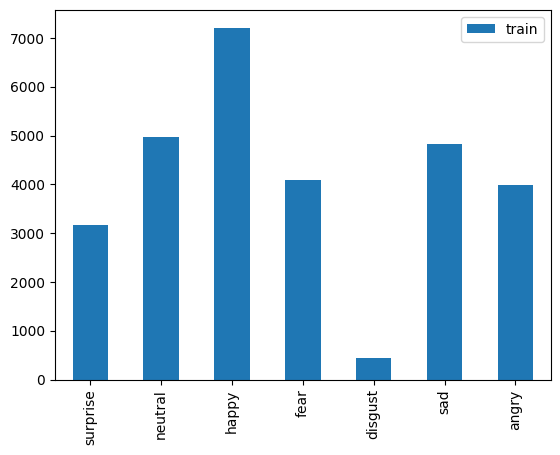

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

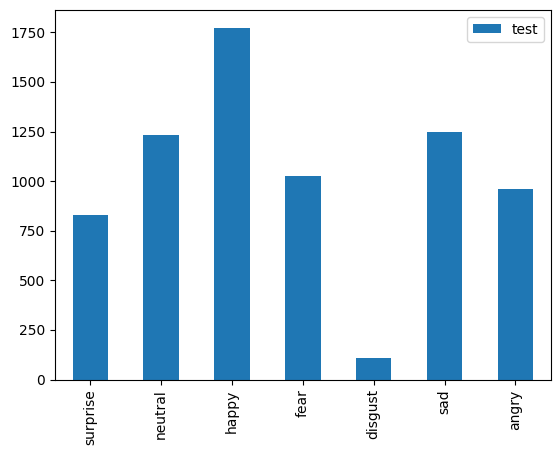

In [ ]:
test_count.transpose().plot(kind='bar')

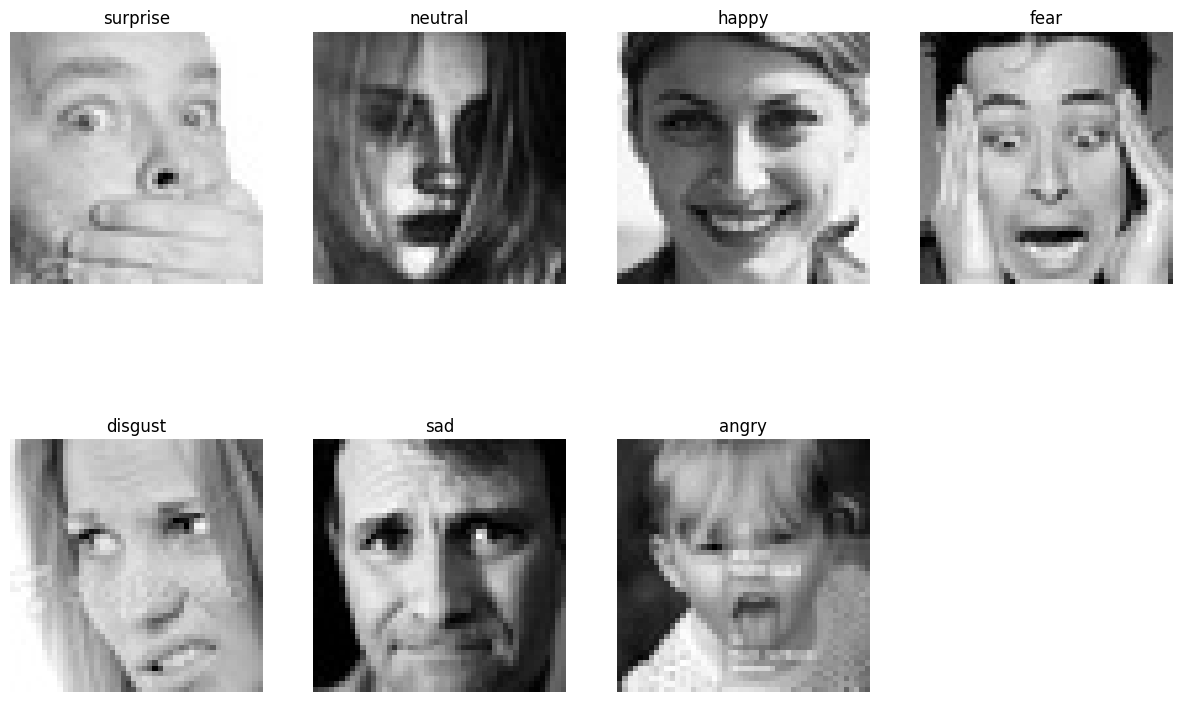

In [ ]:
emotions=os.listdir(train_dir)
plt.figure(figsize=(15,15))
for i,emotion in enumerate(emotions,1):
  folder=os.path.join(train_dir,emotion)
  img_path=os.path.join(folder,os.listdir(folder)[42])
  img=plt.imread(img_path)
  ax=plt.subplot(3,4,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')

In [ ]:
def plot_images_from_directory(directory_path,class_name,num_images=9):
  image_filenames=os.listdir(directory_path)
  if len(image_filenames)<num_images:
    print(f"Only found {len(image_filenames)} images in {directory_path}")
    num_images=len(image_filenames)
  selected_images=random.sample(image_filenames,num_images)
  fig,axes=plt.subplots(3,3,figsize=(5,5))
  axes=axes.flatten()
  for i,img_name in enumerate(selected_images):
    img_path=os.path.join(directory_path,img_name)
    image=load_img(img_path)
    axes[i].imshow(image)
    axes[i].set_title(class_name)
    axes[i].axis('off')
  plt.tight_layout()
  plt.show()

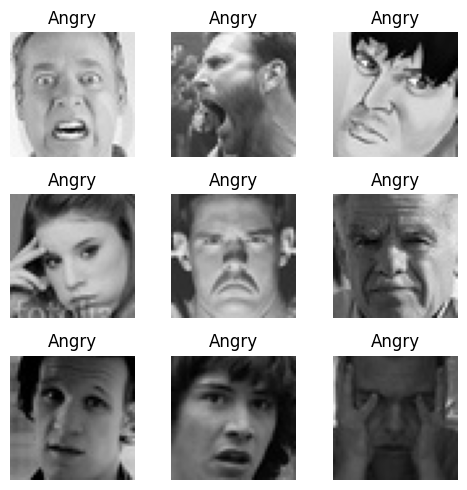

In [ ]:
angry_directory_path='/content/train/angry'
plot_images_from_directory(angry_directory_path,class_name='Angry')
#

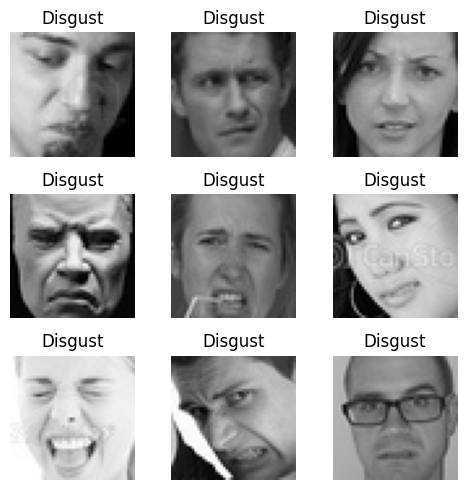

In [ ]:
disgust_directory_path='/content/train/disgust'
plot_images_from_directory(disgust_directory_path,class_name='Disgust')
#

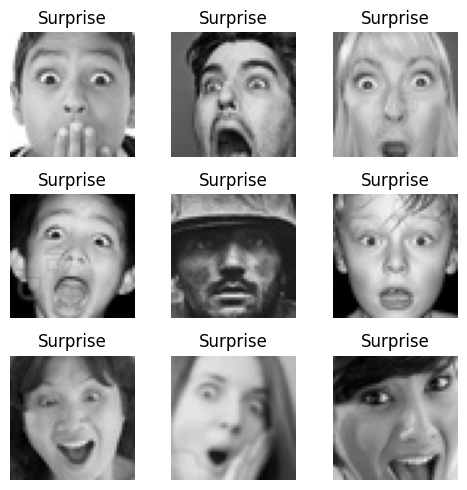

In [ ]:
surpirse_directory_path='/content/train/surprise'
plot_images_from_directory(surpirse_directory_path,class_name='Surprise')
#

In [ ]:
image='/content/train/angry/Training.10118481.jpg'
cv2.imread(image)
if img is not None:
  print("shape:",img.shape)
else:
  print("Failed to load image")


shape: (48, 48)


In [ ]:
image_path='/content/train/angry/Training.10118481.jpg'
img=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
if img is not None:
  print("shape:",img.shape)
else:
  print("Failed to load image")

Failed to load image


In [ ]:
train_data_dir='/content/train'
test_data_dir='/content/test'

In [ ]:
img_width,img_height=48,48
batch_size=64
epochs=10
num_classes=7

In [ ]:
data_generator=ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)
validation_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)
test_generator=data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels=train_generator.class_indices
print(train_class_labels)
validation_class_labels=validation_generator.class_indices
print(validation_class_labels)
test_class_labels=test_generator.class_indices
print(test_class_labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), kernel_initializer='glorot_uniform', padding='same', activation='relu', input_shape=(img_width, img_height, 1)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      18,875,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

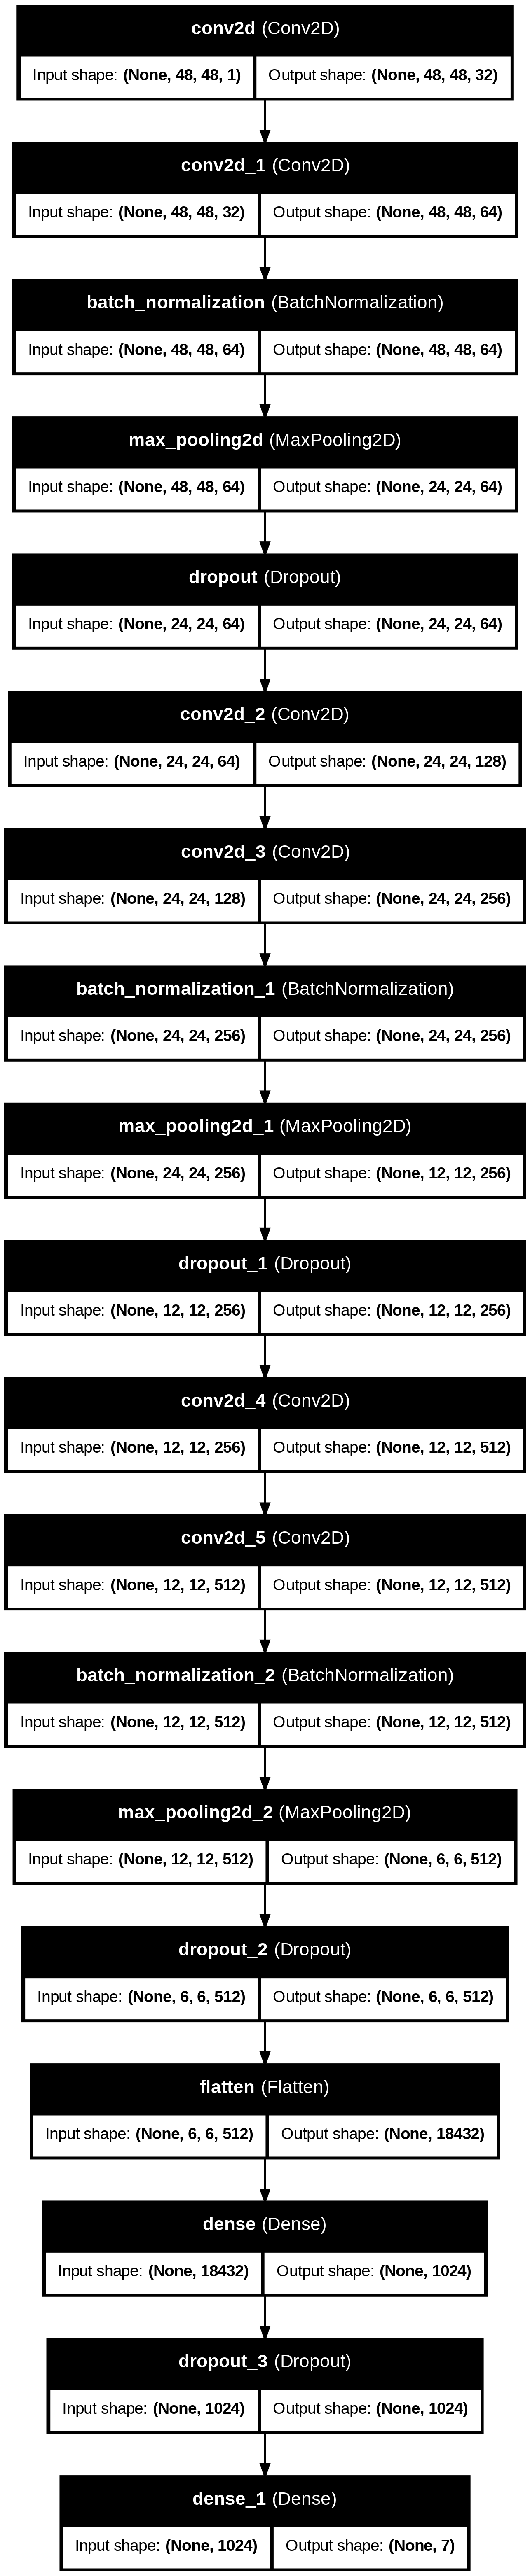

In [ ]:
plot_model(model,to_file=os.path.join(model_dir,'model_plot.png'),show_shapes=True,show_layer_names=True)

In [ ]:
cnn_path='/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name='Custom_CNN_model.keras'
chk_path=os.path.join(cnn_path,name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=chk_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [ ]:

earlystop = EarlyStopping(monitor='val_loss', patience=6, verbose=1, min_delta=0.0001)


In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)

In [ ]:
csv_logger=CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
callbacks=[checkpoint,earlystop,reduce_lr,csv_logger]

In [ ]:
train_steps_per_epoch=train_generator.samples//train_generator.batch_size+1
validation_steps=validation_generator.samples//validation_generator.batch_size+1
test_steps=test_generator.samples//test_generator.batch_size+1

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2309 - loss: 13.3046
Epoch 1: val_accuracy improved from inf to 0.18603, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 61s 115ms/step - accuracy: 0.2310 - loss: 13.3019 - val_accuracy: 0.1860 - val_loss: 17.8561 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3156 - loss: 10.5711
Epoch 2: val_accuracy did not improve from 0.18603
359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - accuracy: 0.3156 - loss: 10.5695 - val_accuracy: 0.3654 - val_loss: 9.7048 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3760 - loss: 8.3414
Epoch 3: val_accuracy did not improve from 0.18603
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.3760 - loss: 8.3400 - val_accuracy: 0.4036 - val_loss: 7.0681 - learning_rate: 1.0000e-04
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/st

In [ ]:
def plot_training_history(history):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs=range(1,len(acc)+1)
  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(epochs,acc,'r',label='Training Accuracy')
  plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(epochs,loss,'r',label='Training Loss')
  plt.plot(epochs,val_loss,'b',label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.show()

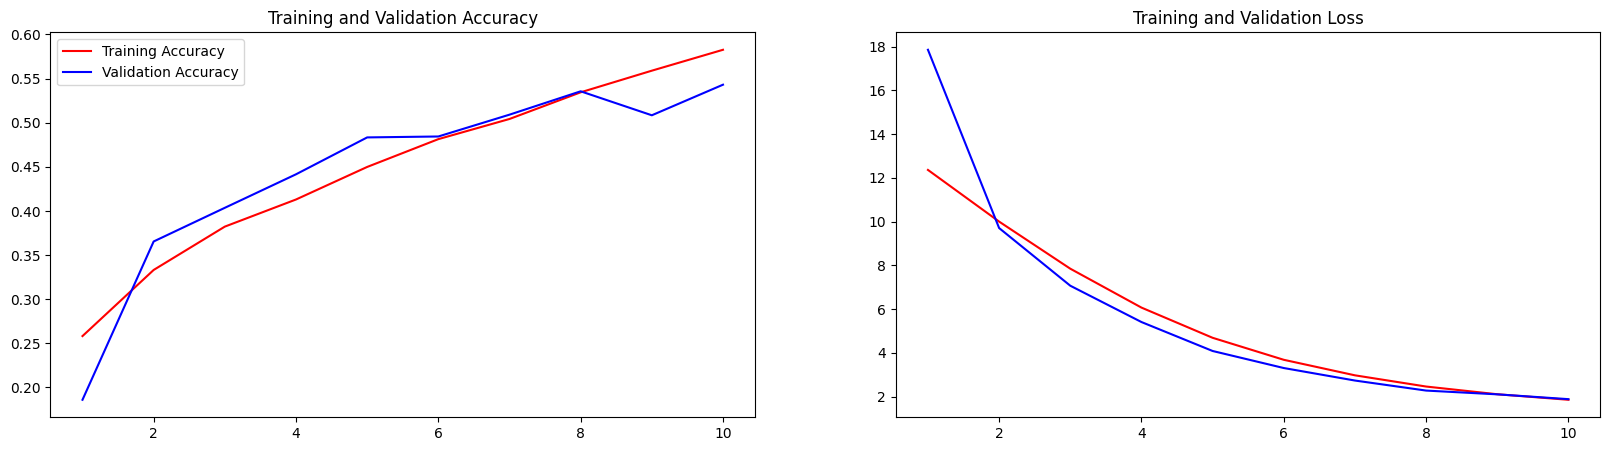

In [ ]:
plot_training_history(history)

In [ ]:
train_loss,train_accu=model.evaluate(train_generator)
print(f'Training Loss: {train_loss}')
print(f'Training Accuracy: {train_accu}')

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6176 - loss: 1.6588
Training Loss: 1.6627132892608643
Training Accuracy: 0.6174242496490479


In [ ]:
test_loss,test_accu=model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accu}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5496 - loss: 1.8556
Test Loss: 1.8681367635726929
Test Accuracy: 0.5463917255401611


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

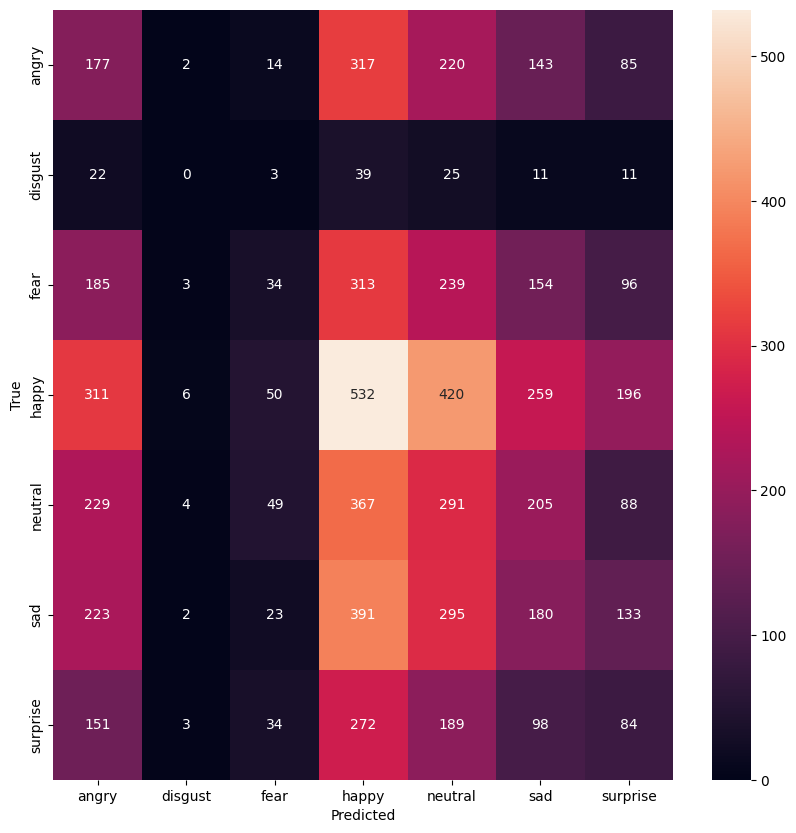

In [ ]:
true_classes=test_generator.classes
pred_classes=model.predict(test_generator)
pred_classes=np.argmax(pred_classes,axis=1)
class_labels=list(test_generator.class_indices.keys())
cm=confusion_matrix(true_classes,pred_classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt

In [ ]:
report=classification_report(true_classes,pred_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.14      0.18      0.16       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.03      0.06      1024
       happy       0.24      0.30      0.27      1774
     neutral       0.17      0.24      0.20      1233
         sad       0.17      0.14      0.16      1247
    surprise       0.12      0.10      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


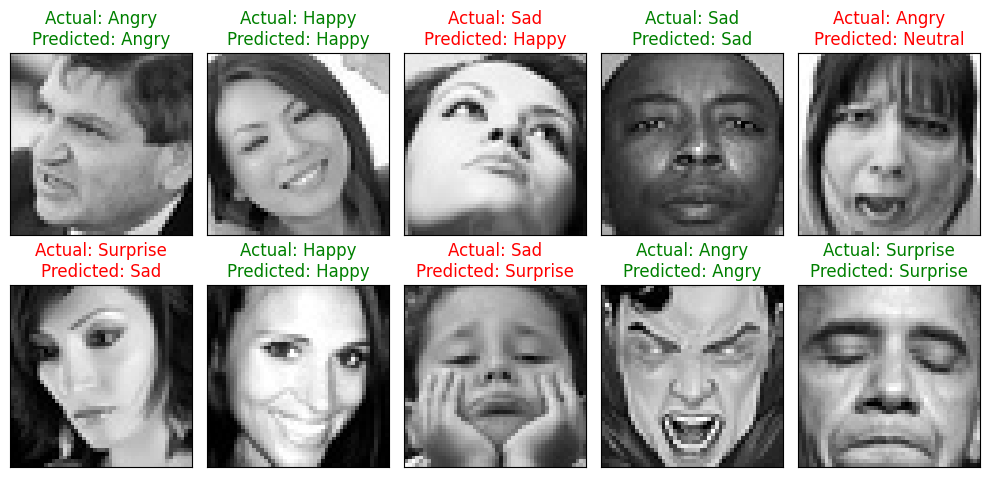

In [ ]:
# Assuming Emotion_Classes, test_generator, and model are already defined
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
batch_size = test_generator.batch_size

# Randomly select a batch and an image index within that batch
Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 10)  # Ensure there are 10 images available

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

# Iterate over the subplots and display images with predictions
for i, ax in enumerate(axes.flat):
    # Get the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index + i]
    Random_Img_Label = test_generator[Random_batch][1][Random_Img_Index + i]

    # Get the model's prediction
    Model_Prediction = np.argmax(model.predict(np.expand_dims(Random_Img, axis=0)), axis=1)

    # Display the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')

    # Set the title with actual and predicted labels
    color = 'green' if np.argmax(Random_Img_Label) == Model_Prediction else 'red'
    ax.set_title(f'Actual: {Emotion_Classes[np.argmax(Random_Img_Label)]}\nPredicted: {Emotion_Classes[Model_Prediction[0]]}', color=color)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
train_data_dir='/content/train'
test_data_dir='/content/test'
img_width,img_height=48,48
batch_size=64
epochs=10
num_classes=7
data_generator=ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                  )
test_data_generator=ImageDataGenerator(rescale=1./255)
train_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)
validation_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)
test_generator=test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
image_path='/content/train/angry/Training_10334355.jpg'
img=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

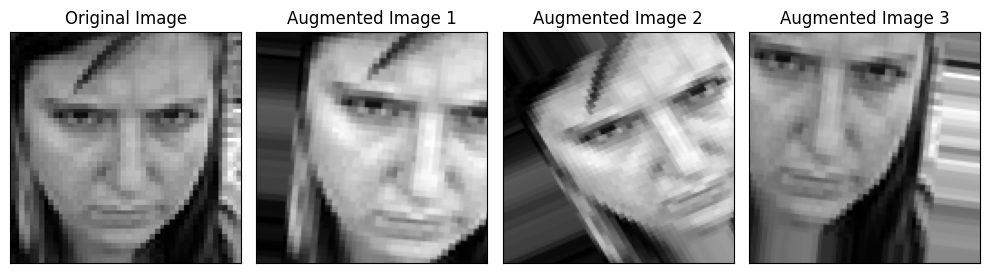

In [ ]:
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1, img_width, img_height, 1))

# Create an ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5), subplot_kw={'xticks':[], 'yticks':[]})

# Original image
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')

# Augmented images
for i in range(1, 4):
    augmented_image = data_generator.random_transform(img_array[0])  # Apply transformation
    axes[i].imshow(augmented_image[:, :, 0], cmap='gray')
    axes[i].set_title(f'Augmented Image {i}')

plt.tight_layout()
plt.show()

In [ ]:
img_width, img_height = 48, 48
num_classes = 7

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 1)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),  # Fixed the typo here
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
cnn_path='/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name='Custom_CNN_model.keras'
chk_path=os.path.join(cnn_path,name)
chk_path
#

'/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_model.keras'

In [ ]:
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=chk_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='min'
)
earlystop = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)

csv_logger=CSVLogger(os.path.join(cnn_path,'training.log'))
callbacks=[checkpoint,earlystop,reduce_lr,csv_logger]
train_steps_per_epoch=train_generator.samples//train_generator.batch_size+1
validation_steps=validation_generator.samples//validation_generator.batch_size+1
test_steps=test_generator.samples//test_generator.batch_size+1
history=model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1952 - loss: 2.6326
Epoch 1: val_accuracy improved from inf to 0.17331, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - accuracy: 0.1953 - loss: 2.6315 - val_accuracy: 0.1733 - val_loss: 2.0326 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2283 - loss: 1.8672
Epoch 2: val_accuracy did not improve from 0.17331
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.2283 - loss: 1.8672 - val_accuracy: 0.2543 - val_loss: 1.9259 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2394 - loss: 1.8124
Epoch 3: val_accuracy did not improve from 0.17331
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2394 - loss: 1.8124 - val_accuracy: 0.2613 - val_loss: 1.9429 - learning_rate: 1.0000e-04
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/st

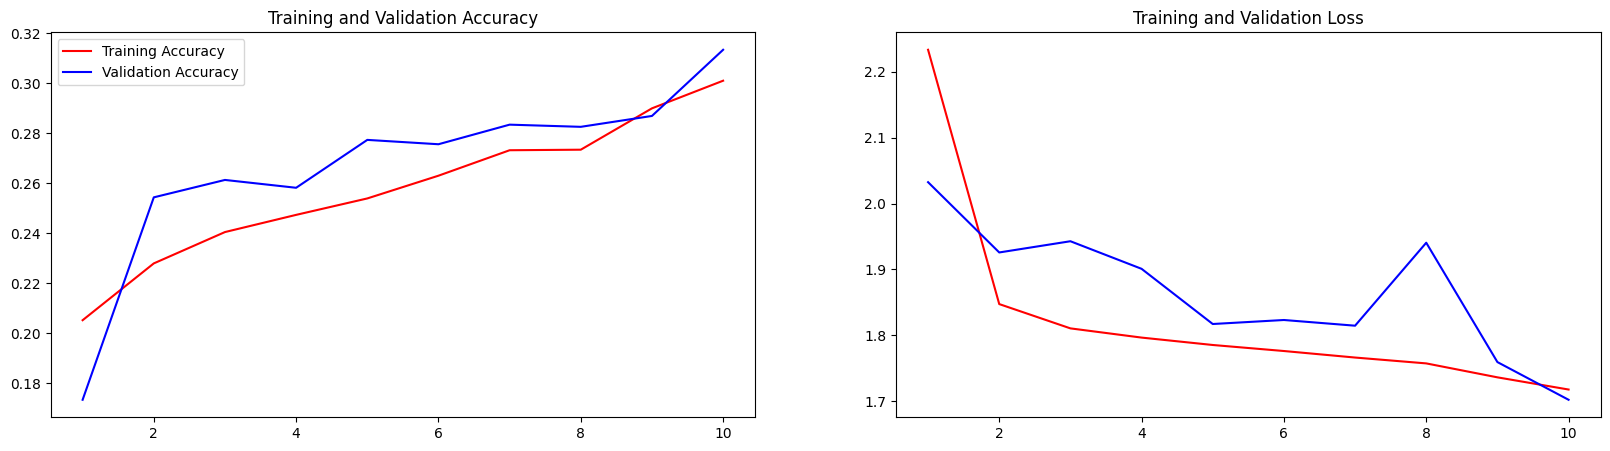

In [ ]:
plot_training_history(history)

In [ ]:
train_loss,train_accu=model.evaluate(train_generator)
print(f'Training Loss: {train_loss}')
print(f'Training Accuracy: {train_accu}')
#
test_loss,test_accu=model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accu}')
#


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.3113 - loss: 1.6876
Training Loss: 1.6876143217086792
Training Accuracy: 0.31134623289108276
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3542 - loss: 1.6350
Test Loss: 1.6213765144348145
Test Accuracy: 0.35455557703971863


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

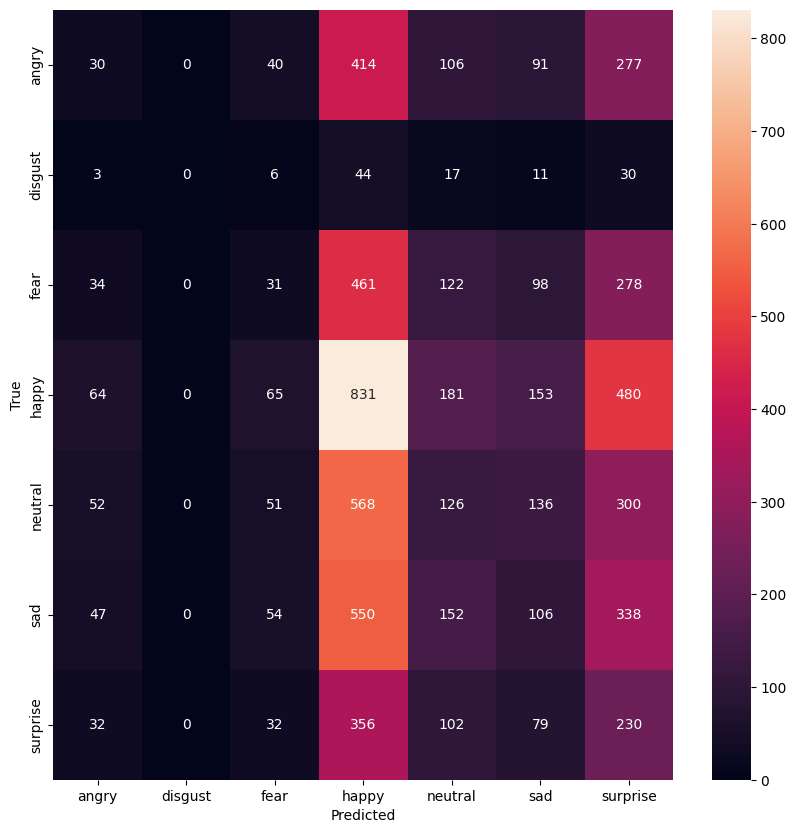

In [ ]:
true_classes=test_generator.classes
pred_classes=model.predict(test_generator)
pred_classes=np.argmax(pred_classes,axis=1)
class_labels=list(test_generator.class_indices.keys())
cm=confusion_matrix(true_classes,pred_classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt